<a href="https://play-ashburn.neurodesk.org/v2/gh/neurodesk/example-notebooks/main?labpath=/home/jovyan/examples/example-notebooks/template.ipynb" target="_parent"><img src="https://img.shields.io/badge/launch-binder-579aca.svg?logo=" alt="Open In Binder"/>  </a>
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>   </a>

# First and Second Level fMRI Analysis with SPM

__Author:__ Monika Doerig

__Citation:__ 

- Wakeman, DG and Henson, RN (2021). Multisubject, multimodal face processing. OpenNeuro. [Dataset] doi: [10.18112/openneuro.ds000117.v1.0.5](https://openneuro.org/datasets/ds000117/versions/1.0.5)

- Wakeman, D.G. & Henson, R.N. (2015). A multi-subject, multi-modal human neuroimaging dataset. Sci. Data 2:150001 doi: 10.1038/sdata.2015.1



__Useful resources:__ 

- SPM Tutorial on event-related fMRI: https://www.fil.ion.ucl.ac.uk/spm/docs/tutorials/fmri/event/

- SPM Manual,  group face fMRI: https://www.fil.ion.ucl.ac.uk/spm/docs/manual/faces_group/face_group/#introduction

- SPM Wikibooks, group analysis: https://en.wikibooks.org/wiki/SPM/Group_Analysis / https://www.fil.ion.ucl.ac.uk/spm/docs/wikibooks/Group_Analysis/

- Nipype Documentation: fMRI: Famous vs non-famous faces in SPM: https://nipype.readthedocs.io/en/latest/users/examples/fmri_spm_face.html

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


## Introduction

The fMRI dataset used for this example is part of a multi-subject, multi-modal (sMRI, fMRI, MEG, EEG) neuroimaging dataset on face processing. It contains data in BIDS format on sixteen healthy volunteers. The data was recoreded while the volunteers performed multiple runs of hundreds of trials of a simple perceptual task on pictures of familiar, unfamiliar and scrambled faces during two visits to the laboratory. 

The facial stimuli consisted of two groups of 300 greyscale photos, half of which were of famous people and half of which were of non-famous people (unknown to the participants). 
Each scrambled face was created either from the famous face or the non-famous face of the same stimulus number. Additionally, each image was presented twice to the participants. The second presentation occurred either immediately after the first presentation (Immediate Repeats) or after 5–15 intervening stimuli (Delayed Repeats), with 50% of each type of repeat.
To ensure that each stimulus received equal attention, participants were instructed to use their left or right index finger to press one of two keys (assignment counter-balanced across participants). They determined the symmetry of each image by pressing a key based on whether they perceived it to be 'more' or 'less symmetric' than average.

In the original paper (Wakeman & Henson, 2015), the repetition manipulation was not distinguished, meaning that initial and repeated presentations were treated identically without considering the timing of the repeats.

To illustrate the setup of a 3x2 factorial design analysis (familiar vs. unfamiliar vs. scrambled faces) x (1st vs. 2nd presentation) in an SPM Nipype workflow, the event files will be adapted accordingly. Each stimulus type will be labeled as either the first or second presentation. However, for simplicity, no distinction is made between immediate and delayed repetitions, resulting in 6 stimulus types (conditions): Familiar-Rep1 (F1), Familiar-Rep2 (F2), Unfamiliar-Rep1 (U1), Unfamiliar-Rep2 (U2), Scrambled-Rep1 (S1), and Scrambled-Rep2 (S2).

__Examples of a familiar, unfamiliar and scrambled face:__

In [3]:
PATTERN_STIMULI = "stimuli/func/*001.bmp"

!datalad install https://github.com/OpenNeuroDatasets/ds000117.git
!cd ds000117 && datalad get $PATTERN_STIMULI

action summary:
  get (notneeded: 6)


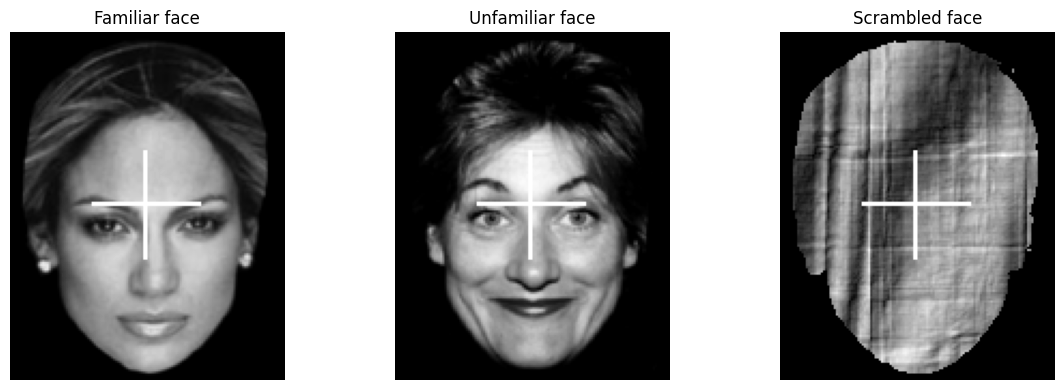

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Load the .bmp images
familiar = imread('ds000117/stimuli/func/f001.bmp')
unfamiliar = imread('ds000117/stimuli/func/u001.bmp')
scrambled = imread('ds000117/stimuli/func/s001.bmp')

# Create a Matplotlib figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each image on a subplot
axes[0].imshow(familiar, cmap='gray')
axes[0].set_title('Familiar face')
axes[0].axis('off')

axes[1].imshow(unfamiliar, cmap='gray')
axes[1].set_title('Unfamiliar face')
axes[1].axis('off')

axes[2].imshow(scrambled, cmap='gray')
axes[2].set_title('Scrambled face')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Download Data and install Python modules

In [5]:
# get func data of the mri session of 9 individuals  
PATTERN = "sub-0*/ses-mri/func"

!datalad install https://github.com/OpenNeuroDatasets/ds000117.git
!cd ds000117 && datalad get $PATTERN

action summary:
  get (notneeded: 9)


In [6]:
# get preprocessed normalized func images of 9 individuals  
PATTERN_PREP = "sub-0*/ses-mri/func/*space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz"

!datalad install https://github.com/OpenNeuroDerivatives/ds000117-fmriprep.git
!cd ds000117-fmriprep && datalad get $PATTERN_PREP

action summary:
  get (notneeded: 81)


In [7]:
# Installations
!pip install nilearn pandas

## Load SPM and import Python and Nipype modules

In [8]:
import lmod
await lmod.purge(force=True)
await lmod.load('spm12/r7771')
await lmod.list()

['spm12/r7771']

In [9]:
import pandas as pd
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import json
import os
from os.path import join as opj
from scipy.io import loadmat

In [10]:
import nipype.algorithms.modelgen as model
from nipype.interfaces import spm
from nipype.interfaces.io import DataSink, DataGrabber
from nipype.interfaces.utility import IdentityInterface, Function
from nipype import Node, Workflow, MapNode
from nipype.algorithms.misc import Gunzip

In [11]:
import nipype
NIPYPE_VERSION = nipype.__version__
print(NIPYPE_VERSION)

1.8.6


In [12]:
if NIPYPE_VERSION <= '1.8.6':
    print('Contrasts need to be defined manually and wont be computed automatically when they are defined in Level1Design using the factor_info parameter')
    
# starting in nipype version 1.8.7., when factor_info parameter is used in Level1design T and F contrasts (ess*, con*, spmF* and spmT* images) 
# are created automatically by in EstimateModel by SPM

Contrasts need to be defined manually and wont be computed automatically when they are defined in Level1Design using the factor_info parameter


## Analysis

### 1. First Level Analysis

#### Prepare Data Input

In [13]:
#base directories
data_base_dir = os.getcwd() 
experiment_dir = opj(data_base_dir, 'spm_analysis/') #where to store the working and datasink directories

#list of subject identifiers and runs
sub_list =  ['01', '02', '03', '04', '05', '06', '07', '08', '09']

#only take run 1 and 2 for computational reasons
run_id = [1,2]

In [14]:

#TR of functional images
with open(opj(data_base_dir,'ds000117/task-facerecognition_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = float(task_info['RepetitionTime'])
print('Repetition Time:', TR)

Repetition Time: 2.0


#### Start the workflow

In [15]:
wf = Workflow(name='level1_spm', base_dir=experiment_dir)
wf.config["execution"]["crashfile_format"] = "txt"

#### Input stream

In [16]:
infosource = Node(IdentityInterface(fields=["subject_id"]),
                  name="infosource")
infosource.iterables = [("subject_id", sub_list)]

###### SPM12 can accept NIfTI files as input, but only if they are not compressed ('unzipped'). Use Gunzip node to unzip the files, before feeding them it to the model specification node.

In [17]:
gunzip_func = MapNode(Gunzip(), name='gunzip_func', iterfield='in_file')

In [18]:
datagrabber = Node(interface=DataGrabber(
        infields=["subject_id","run_id"], outfields=["func", "events"]
    ), name="datagrabber"
)

# Specify task names and return a sorted filelist to ensure to match files to correct runs
datagrabber.inputs.run_id = run_id
datagrabber.inputs.sort_filelist = True
datagrabber.inputs.template = "*"
datagrabber.inputs.base_directory = data_base_dir

# Define arguments fill the wildcards in the below paths 
datagrabber.inputs.template_args = dict(
    func=[["subject_id","subject_id","run_id"]],
    events=[["subject_id","subject_id", "run_id"]]
)

datagrabber.inputs.field_template = dict(
    func= "ds000117-fmriprep/sub-%s/ses-mri/func/sub-%s_ses-mri_task-facerecognition_run-%d_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz",
    events="ds000117/sub-%s/ses-mri/func/sub-%s_ses-mri_task-facerecognition_run-0%d_events.tsv", 
)

wf.connect([
        (infosource, datagrabber, [("subject_id", "subject_id")])])

wf.connect([(datagrabber, gunzip_func, [('func', 'in_file')])])

#### First-level GLM
The subsequent task involves obtaining information such as stimuli type, onset, duration, and other regressors for integration into the GLM model. To accomplish this, a helper function needs to be created, which will be referred to as subjectinfo.

A TSV file for each run looks like this: 

In [19]:
!cat ds000117/sub-01/ses-mri/func/sub-01_ses-mri_task-facerecognition_run-01_events.tsv

onset	duration	circle_duration	stim_type	trigger	button_pushed	response_time	stim_file
0	.908	.534	FAMOUS	5	4	2.158	func/f013.bmp
3.273	.962	.586	FAMOUS	6	4	1.233	func/f013.bmp
6.647	.825	.546	UNFAMILIAR	13	4	1.183	func/u014.bmp
9.838	.968	.597	UNFAMILIAR	14	4	.930	func/u014.bmp
12.978	.904	.415	UNFAMILIAR	13	7	1.068	func/u016.bmp
16.219	.859	.558	UNFAMILIAR	14	7	1.207	func/u016.bmp
19.443	.804	.585	UNFAMILIAR	13	4	1.286	func/u010.bmp
22.55	.879	.526	UNFAMILIAR	14	4	1.008	func/u010.bmp
25.606	.866	.416	SCRAMBLED	17	7	1.929	func/s002.bmp
28.697	.884	.461	SCRAMBLED	18	4	1.300	func/s002.bmp
31.319	20.000	20.000	n/a	999	20000	20.000	func/i999.bmp
51.898	.974	.543	FAMOUS	5	7	2.477	func/f004.bmp
55.173	.925	.534	SCRAMBLED	17	7	1.372	func/s008.bmp
58.313	.985	.439	UNFAMILIAR	13	4	1.431	func/u012.bmp
61.587	.862	.533	FAMOUS	5	4	1.086	func/f012.bmp
64.677	.869	.461	FAMOUS	6	4	1.018	func/f012.bmp
67.75	.804	.446	SCRAMBLED	17	7	1.267	func/s007.bmp
70.774	.873	.445	SCRAMBLED	17	7	1.211	func/s011.b

As mentioned in the introduction, these event files will be adapted in the function 'subjectinfo' to demonstrate the setup of a 3x2 factorial design analysis. The original stimulus types (stim_types) FAMOUS, NONFAMILIAR, SCRAMBLED  will be replaced with F1 (first presentation of an image of a famous face)/ F2 (second presentation of image), U1/U2 and S1/S1 due to the first or second occurance of the respective stimulus file (stim_file). In addition, stimuli of stimulus type n/a are deleted.

In [20]:
# Get the subject information: to create a GLM model, Nipype needs a list of Bunch objects per run (session)

def subjectinfo(events):

    # packages need to be imported within the function for node to work (function is executed in a standalone environment)
    from nipype.interfaces.base import Bunch
    import pandas as pd
    from collections import OrderedDict

    trialinfo = pd.read_table(events)

    # Filter out rows where stim_type does not contain 'FAMOUS', 'UNFAMILIAR', or 'SCRAMBLED' --> n/a
    trialinfo = trialinfo[trialinfo['stim_type'].isin(['FAMOUS', 'UNFAMILIAR', 'SCRAMBLED'])].reset_index(drop=True)
    
    # Create a dictionary to store the count of occurrences for each stim_file
    stim_file_count = {}
    
    
    # Iterate over each row in the dataframe
    for index, row in trialinfo.iterrows():
        # Get the stim_file value for the current row
        stim_file = row['stim_file']
        
        # If the stim_file is not in the stim_file_count dictionary, add it with count 1
        if stim_file not in stim_file_count:
            stim_file_count[stim_file] = 1
        else:
            # Increment the count for the stim_file and update the dictionary
            stim_file_count[stim_file] += 1
        
        # Get the count of occurrences for the current stim_file
        count = stim_file_count[stim_file]
        
        # Determine the new stim_type based on the stim_file and its count
        if 'FAMOUS' in row['stim_type']:
            new_stim_type = f'F{count}'
        elif 'UNFAMILIAR' in row['stim_type']:
            new_stim_type = f'U{count}'
        else:
            # If it's not 'FAMOUS' or 'UNFAMILIAR', it must be 'SCRAMBLED'
            new_stim_type = f'S{count}'
        
        # Update the stim_type in the dataframe
        trialinfo.at[index, 'stim_type'] = new_stim_type

    
    # Define the custom sorting order (instead of an alphabetic ordering F1, F2, S1, S2, U1, U2
    sorting_order = OrderedDict([('F1', 1), ('F2', 2), ('U1', 3), ('U2', 4), ('S1', 5), ('S2', 6)])
    
    conditions = []
    onsets = []
    durations = []
    
    # Group trialinfo by 'stim_type' and iterate over groups
    grouped_trials = trialinfo.groupby('stim_type')
    for group_key in sorting_order.keys():  # Use keys() to iterate over keys
        group_data = grouped_trials.get_group(group_key)
        conditions.append(group_key)
        onsets.append(group_data['onset'].tolist())
        durations.append(group_data['duration'].tolist())

    subject_info = Bunch(conditions=conditions, 
                     onsets=onsets, 
                     durations=durations)
        
    return subject_info
    


getsubjectinfo = MapNode(Function(input_names=['events'],
                                output_names=['subject_info'],
                                function=subjectinfo),
                                name='getsubjectinfo', iterfield=['events'])

In [21]:
wf.connect(datagrabber, 'events', getsubjectinfo, 'events')

In [22]:
modelspec = Node(model.SpecifySPMModel(concatenate_runs=True,
                                input_units = 'secs',
                                output_units = 'secs',
                                time_repetition= TR, 
                                high_pass_filter_cutoff=128), #in secs, slow signal drifts with a period > 128 will be removed
                                name='modelspec')
                              
wf.connect(getsubjectinfo, 'subject_info', modelspec,'subject_info')
wf.connect(gunzip_func, 'out_file', modelspec, 'functional_runs')

##### Level1Design: canonical HRF

The design matrix will be constructed without including derivatives of the hemodynamic response function (HRF) and therefore assumes a constant delay and dispersion for the hemodynamic response.

##### Starting in nipype version 1.8.7., when factor_info parameter is used in Level1design, T and F contrasts (ess*, con*, spmF* and spmT* images) are created automatically in EstimateModel by SPM. They need to be connected directly to a data output module

The following lines automatically inform SPM to create a default set of
contrats for a factorial design.

In [ ]:
# Level1Design - Generates an SPM design matrix
level1design = Node(spm.Level1Design(bases={'hrf':{'derivs': [0,0]}}, # no derivatives
                                timing_units='secs',
                                interscan_interval=TR, 
                                microtime_onset=8, #The onset/time-bin in seconds for alignment
                                microtime_resolution=16, #Number of time-bins per scan in secs
                                mask_threshold=0.8,
                                global_intensity_normalization='none',
                                volterra_expansion_order=1, #do not model interactions
                                model_serial_correlations='AR(1)'), # serial correlations --> autoregressive AR(1) model during Classical (ReML) parameter estimation
                                name='level1design')

if NIPYPE_VERSION > '1.8.6':
# Factors need to match conditions: product of levels (here 6) needs to match number of condition names --> F1, F2, U1, U2, S1, S2
    level1design.inputs.factor_info = [dict(name = 'Face', levels = 3),
                                        dict(name = 'Rep', levels = 2)]
                            
wf.connect(modelspec,'session_info', level1design, 'session_info')

In [24]:
# EstimateModel - estimate the parameters of the model 
level1estimate = Node(spm.EstimateModel(estimation_method={'Classical':1}), #EstimateModel2
                                   name='level1estimate')

wf.connect(level1design, 'spm_mat_file', level1estimate, 'spm_mat_file')

##### Specify GLM contrast for nipype<=1.8.6 
Contrasts need to be set up manually as they are not created automatically in EstimateModel when factor_info parameter is used in Level1Design.


In [25]:
condition_names =   ['F1', 'F2', 'U1', 'U2', 'S1', 'S2'] #The condition names must match the names listed in the subjectinfo function described above.

cond1 = ('Positive effect of condition', 'T', condition_names, [1, 1, 1, 1, 1, 1])

# positive effect face
face1 = ('Positive effect of Face_1', 'T', condition_names, [1, 1, -1, -1, 0, 0])
face2 = ('Positive effect of Face_2', 'T', condition_names, [0, 0, 1, 1, -1, -1])

# rep1 > rep2
rep1 = ('Positive effect of Rep', 'T', condition_names, [1, -1, 1, -1, 1, -1])

# positive interaction face x rep
int1 = ('Positive interaction of Face x Rep1', 'T', condition_names, [1, -1, -1, 1, 0, 0])
int2 = ('Positive interaction of Face x Rep2', 'T', condition_names, [0, 0, 1, -1, -1, 1])

contf1 = ['Average effect condition', 'F', [cond1]]
contf2 = ['Main effect Face', 'F', [face1, face2]]
contf3 = ['Main effect Rep', 'F', [rep1]]
contf4 = ['Interaction: Face x Rep', 'F', [int1, int2]]

contrasts = [contf1, contf2, contf3, contf4, cond1, face1, face2,  rep1,  int1, int2]

In [26]:
# EstimateContrast - explicit contrast estimation with nipype version <= 1.8.6 with the defined contrast list

if NIPYPE_VERSION <= '1.8.6':
    level1conest = Node(spm.EstimateContrast(), 
                        name='level1conest')
    level1conest.inputs.contrasts = contrasts
    
                                                        
    wf.connect([(level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                                ('beta_images','beta_images'),
                                            ('residual_image','residual_image')])])

#### Output stream

In [27]:
# save all results into one
datasink = Node(DataSink(), name='sinker')
datasink.inputs.base_directory=opj(experiment_dir, "level1_spm_results")

In [28]:
wf.connect(infosource, 'subject_id', datasink, 'container')

if NIPYPE_VERSION <= '1.8.6':
    wf.connect([(level1conest, datasink,    [('spm_mat_file', '1stLevel.@spm_mat'),
                                            ('spmT_images', '1stLevel.@T'),
                                            ('con_images', '1stLevel.@con'),
                                            ('spmF_images', '1stLevel.@F'),
                                            ('ess_images', '1stLevel.@ess')]),
                                            ])
# starting in nipype version 1.8.7., when factor_info parameter is used in Level1Design T and F contrasts (ess*, con*, spmF* and spmT* images) 
# are created automatically by SPM in EstimateModel
else: 
    wf.connect(level1design, 'spm_mat_file', datasink, '1stLevel.@spm_mat')
    wf.connect([(level1estimate, datasink,  [
                                            ('spmT_images', '1stLevel.@T'),
                                            ('con_images', '1stLevel.@con'),
                                            ('spmF_images', '1stLevel.@F'),
                                            ('ess_images', '1stLevel.@ess')]),
                                            ])

In [29]:
subFolders = [('%s/1stLevel' % s, 'sub-%s/' % s) 
               for s in sub_list]

subFolders1 = [('_subject_id_%s'%(s), '')
              for s in sub_list]

subFolders.extend(subFolders1)
datasink.inputs.substitutions = subFolders

240613-06:39:48,46 nipype.workflow INFO:
	 Generated workflow graph: /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level1_spm/graph.png (graph2use=colored, simple_form=True).


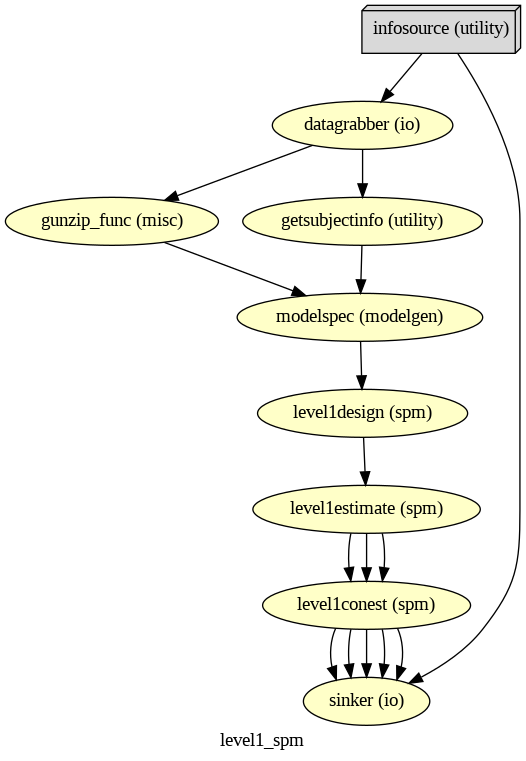

In [30]:
# Create 1st-level analysis output graph
wf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(wf.base_dir, wf.name, 'graph.png'))

In [31]:
wf.run(plugin="MultiProc") #will use all CPUs
#ca. 10 min

240613-06:39:48,76 nipype.workflow INFO:
	 Workflow level1_spm settings: ['check', 'execution', 'logging', 'monitoring']
240613-06:39:48,125 nipype.workflow INFO:
	 Running in parallel.
240613-06:39:48,128 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:39:48,700 nipype.workflow INFO:
	 [Node] Setting-up "level1_spm.datagrabber" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level1_spm/_subject_id_01/datagrabber".
240613-06:39:48,703 nipype.workflow INFO:
	 [Node] Setting-up "level1_spm.datagrabber" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level1_spm/_subject_id_03/datagrabber".
240613-06:39:48,702 nipype.workflow INFO:
	 [Node] Setting-up "level1_spm.datagrabber" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level1_spm/_subject_id_02/datagrabber".
240613-06:39:48,704 nipype.workflow INFO:
	 [Node] Setting-up "level1_spm.datagrabber" in "/mnt/neu

stty: 'standard input': Inappropriate ioctl for device


240613-06:41:43,926 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.499334s.
240613-06:41:43,926 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.532317s.
240613-06:41:43,990 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 63.605568s.
240613-06:41:43,991 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.580354s.
240613-06:41:43,991 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.593839s.
240613-06:41:44,72 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.676236s.
240613-06:41:44,91 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.695045s.
240613-06:41:44,93 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 65.665607s.


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:41:44,225 nipype.workflow INFO:
	 [Job 36] Completed (level1_spm.level1design).
240613-06:41:44,226 nipype.workflow INFO:
	 [Job 37] Completed (level1_spm.level1design).
240613-06:41:44,227 nipype.workflow INFO:
	 [Job 38] Completed (level1_spm.level1design).
240613-06:41:44,228 nipype.workflow INFO:
	 [Job 40] Completed (level1_spm.level1design).
240613-06:41:44,229 nipype.workflow INFO:
	 [Job 41] Completed (level1_spm.level1design).
240613-06:41:44,230 nipype.workflow INFO:
	 [Job 42] Completed (level1_spm.level1design).
240613-06:41:44,231 nipype.workflow INFO:
	 [Job 43] Completed (level1_spm.level1design).
240613-06:41:44,232 nipype.workflow INFO:
	 [Job 44] Completed (level1_spm.level1design).
240613-06:41:44,233 nipype.workflow INFO:
	 [Job 39] Completed (level1_spm.level1design).
240613-06:41:44,235 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:41:44,402 nipype.workflow INFO:


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:43:37,402 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 112.870713s.
240613-06:43:37,645 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.118144s.
240613-06:43:37,690 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.146s.


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:43:37,706 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.169625s.
240613-06:43:37,739 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.207248s.
240613-06:43:37,831 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.287801s.
240613-06:43:37,844 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.307623s.
240613-06:43:37,845 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 113.313924s.


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:43:38,283 nipype.workflow INFO:
	 [Job 45] Completed (level1_spm.level1estimate).
240613-06:43:38,285 nipype.workflow INFO:
	 [Job 46] Completed (level1_spm.level1estimate).
240613-06:43:38,287 nipype.workflow INFO:
	 [Job 47] Completed (level1_spm.level1estimate).
240613-06:43:38,288 nipype.workflow INFO:
	 [Job 48] Completed (level1_spm.level1estimate).
240613-06:43:38,289 nipype.workflow INFO:
	 [Job 49] Completed (level1_spm.level1estimate).
240613-06:43:38,290 nipype.workflow INFO:
	 [Job 50] Completed (level1_spm.level1estimate).
240613-06:43:38,291 nipype.workflow INFO:
	 [Job 51] Completed (level1_spm.level1estimate).
240613-06:43:38,293 nipype.workflow INFO:
	 [Job 52] Completed (level1_spm.level1estimate).
240613-06:43:38,294 nipype.workflow INFO:
	 [Job 53] Completed (level1_spm.level1estimate).
240613-06:43:38,296 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:43:38,502 nipy

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:44:06,195 nipype.workflow INFO:
	 [Node] Finished "level1conest", elapsed time 27.504365s.
240613-06:44:06,286 nipype.workflow INFO:
	 [Job 54] Completed (level1_spm.level1conest).
240613-06:44:06,288 nipype.workflow INFO:
	 [Job 55] Completed (level1_spm.level1conest).
240613-06:44:06,289 nipype.workflow INFO:
	 [Job 56] Completed (level1_spm.level1conest).
240613-06:44:06,289 nipype.workflow INFO:
	 [Job 57] Completed (level1_spm.level1conest).
240613-06:44:06,290 nipype.workflow INFO:
	 [Job 58] Completed (level1_spm.level1conest).
240613-06:44:06,292 nipype.workflow INFO:
	 [Job 59] Completed (level1_spm.level1conest).
240613-06:44:06,293 nipype.workflow INFO:
	 [Job 60] Completed (level1_spm.level1conest).
240613-06:44:06,293 nipype.workflow INFO:
	 [Job 61] Completed (level1_spm.level1conest).
240613-06:44:06,294 nipype.workflow INFO:
	 [Job 62] Completed (level1_spm.level1conest).
240613-06:44:06,296 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready

#### Visualize design matrix and list contrasts

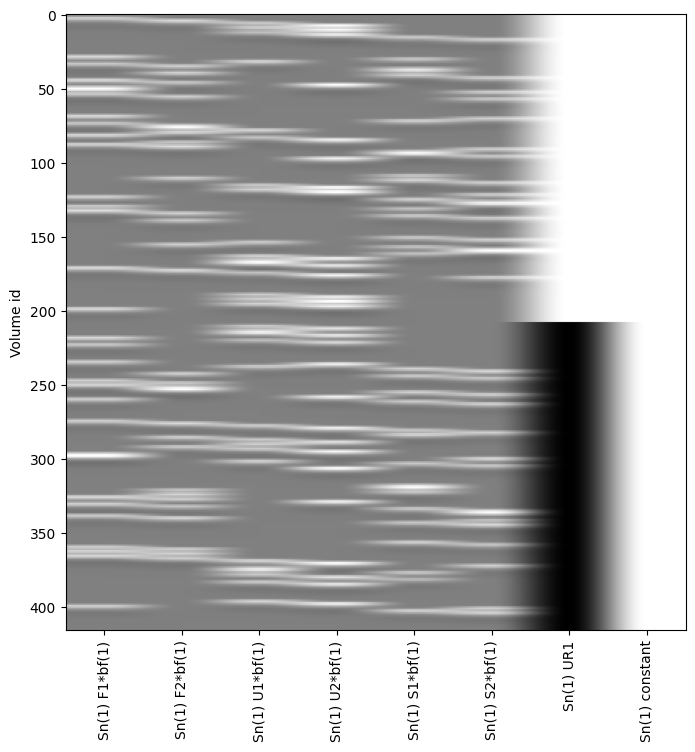

In [32]:
spmmat = loadmat(opj(experiment_dir, 'level1_spm_results/sub-01/SPM.mat'), struct_as_record=False)

designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names =[i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
names_contrast = [spmmat['SPM'][0][0].xCon[0][i].name[0] for i in range(spmmat['SPM'][0][0].xCon.shape[1])]


normed_design=designMatrix / np.abs(designMatrix).max(axis=0)

fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(normed_design, aspect='auto', cmap='gray')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

In [33]:
data = []

xCon_array = spmmat['SPM'][0][0].xCon[0]

# Iterate over each struct in the xCon array, nested loop, iterate over Vspm and Vcon to get filenames
for struct in xCon_array:
    name = struct.name[0]
    stat = struct.STAT[0]
    c = struct.c.flatten().tolist()
    vspm = struct.Vspm[0]
    vcon = struct.Vcon[0]
    for st in vspm:
        vspm_name = st.fname[0]
    for s in vcon:
        vcon_name = s.fname[0]
        
    data.append({"Name": name, "STAT": stat, "c": c, "spm_file": vspm_name, "con_file": vcon_name})

df = pd.DataFrame(data)
df_string = df.to_string(index=False)

print(df_string)


                               Name STAT                                                    c      spm_file     con_file
           Average effect condition    F                             [1, 1, 1, 1, 1, 1, 0, 0] spmF_0001.nii ess_0001.nii
                   Main effect Face    F [1, 0, 1, 0, -1, 1, -1, 1, 0, -1, 0, -1, 0, 0, 0, 0] spmF_0002.nii ess_0002.nii
                    Main effect Rep    F                          [1, -1, 1, -1, 1, -1, 0, 0] spmF_0003.nii ess_0003.nii
            Interaction: Face x Rep    F [1, 0, -1, 0, -1, 1, 1, -1, 0, -1, 0, 1, 0, 0, 0, 0] spmF_0004.nii ess_0004.nii
       Positive effect of condition    T                             [1, 1, 1, 1, 1, 1, 0, 0] spmT_0005.nii con_0005.nii
          Positive effect of Face_1    T                           [1, 1, -1, -1, 0, 0, 0, 0] spmT_0006.nii con_0006.nii
          Positive effect of Face_2    T                           [0, 0, 1, 1, -1, -1, 0, 0] spmT_0007.nii con_0007.nii
             Positive effect of 

### 2. Second Level Analysis

For a factorial design with 2 factors there are 4 effects to test for: an overall effect, 2 main effects and one two-way interaction:

- To test (1) the overall effect, use a [1 1 1 1 1 1] contrast for each subject and take the resulting con images of all subjects into a one-sample t-test at the second level. Then specify a [1] F-contrast (at the second level) to test for significantly non-zero BOLD responses related to the paradigm. 

- To test for (2) the main effect of Factor Repetition (two levels), use a [1 -1 1 -1 1 -1] contrast for each subject and take the resulting con images into a one-sample t-test at the second level.  

- To test for (3) the main effect of Factor Face (three levels), use two contrasts per subject [1 1 -1 -1 0 0] and [0 0 1 1 -1 -1] and take all resulting con images (two per subject) into a two-sample t-test design at the second level. Then, use a [1 0; 0 1] F-contrast to test for this main effect.

- To test for (4) the interaction between Factors Face and Rep, use two contrasts per subject [1 -1 -1 1 0 0] and [0 0 1 -1 -1 1] and take all resulting con images (two per subject) into a two-sample t-test design at the second level. Use then a [1 0; 0 1] F-contrast to test for this interaction effect. 
 


#### 2.1 One Sample T-Test: Overall effect, main effect of repetition

Test for significantly non-zero BOLD responses over all subjects.

- con_0005: Positive effect
- 
- con_0006: Positive Effect F>S 
- con_0007: Positive Effect S>U
- 
- con_0008: Positive Effect of rep1>rep2
- 
- con_0009: Positive Interaction Face (F/S) x Rep 
- con_0010: Positive Interaction Face (S/U) x Rep

In [34]:
wf_2ndlevel_onesample = Workflow(name='level2_spm_1sample', base_dir=experiment_dir)
wf_2ndlevel_onesample.config["execution"]["crashfile_format"] = "txt"

In [35]:
contrast_id = [5, 6, 7, 8, 9, 10] #contrasts con_0005 to con_0010

l2source = Node(DataGrabber(infields= ['con'], outfields=['contrasts']), name='l2source')

l2source.inputs.sort_filelist = True
l2source.inputs.base_directory = opj(experiment_dir, 'level1_spm_results')
l2source.inputs.template = '*'
l2source.inputs.field_template = dict(
   contrasts = '*/con_%04d.nii'
)

# iterate over all contrast images
l2source.iterables = [('con', contrast_id)]

In [36]:
# OneSampleTTest Design
onesamplettestdes = Node(interface=spm.OneSampleTTestDesign(), name="onesampttestdes")

wf_2ndlevel_onesample.connect([(l2source, onesamplettestdes, [('contrasts', 'in_files')])])

In [37]:
# EstimateModel - estimates the model
l2estimate = Node(spm.EstimateModel(estimation_method={'Classical':1}), name='level2estimate')

# EstimateContast - estimates group contrast
l2conestimate = Node(spm.EstimateContrast(group_contrast=True), name = 'level2conestimate')

con_1= ['Group', 'T', ['mean'], [1]]
#con_2= ['Group', 'F', [con_1]] # if an F contrast is also wanted

l2conestimate.inputs.contrasts = [con_1] # con_2, include in list if wanted

# Threshold - thresholds contrasts
level2thresh = Node(spm.Threshold(contrast_index=1,# which contrast in the SPM.mat to use --> here set for con_1: T stat
                                use_topo_fdr=True, # whether to use FDR over cluster extent probabilities
                                use_fwe_correction=False, # whether to use FWE (Bonferroni) correction for initial threshold 
                                extent_threshold=0, # minimum cluster size in voxels
                                height_threshold=0.005, # value for initial thresholding (defining clusters) - voxelwise
                                height_threshold_type='p-value',
                                extent_fdr_p_threshold=0.05), # p threshold on FDR corrected cluster size probabilities
                                name='level2thresh')

wf_2ndlevel_onesample.connect([(onesamplettestdes, l2estimate, [('spm_mat_file', 'spm_mat_file')]),
                    (l2estimate, l2conestimate, [('spm_mat_file', 'spm_mat_file'),
                                                ('beta_images', 'beta_images'),
                                                ('residual_image', 'residual_image')]),
                    (l2conestimate, level2thresh, [('spm_mat_file', 'spm_mat_file'),
                                                    ('spmT_images', 'stat_image')])

                    ])

In [38]:
datasink_2nd = Node(DataSink(), name='datasink_2nd')
datasink_2nd.inputs.base_directory=opj(experiment_dir, 'level2_spm_results_1sample')

wf_2ndlevel_onesample.connect([(l2conestimate, datasink_2nd, [('spm_mat_file', '2ndLevel.@spm_mat'),
                                                    ('spmT_images', '2ndLevel.@T'),
                                                    ('con_images', '2ndLevel.@con')]),
                    (level2thresh, datasink_2nd, [('thresholded_map',
                                                '2ndLevel.@threshold')])                               
                    ])

In [39]:
#replace _con_ with con
subFolders = [('2ndLevel/', '')] 

subFolders1 = [('_con_', 'con')] 
subFolders.extend(subFolders1)

datasink_2nd.inputs.substitutions = subFolders

240613-06:44:11,680 nipype.workflow INFO:
	 Generated workflow graph: /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/graph.png (graph2use=colored, simple_form=True).


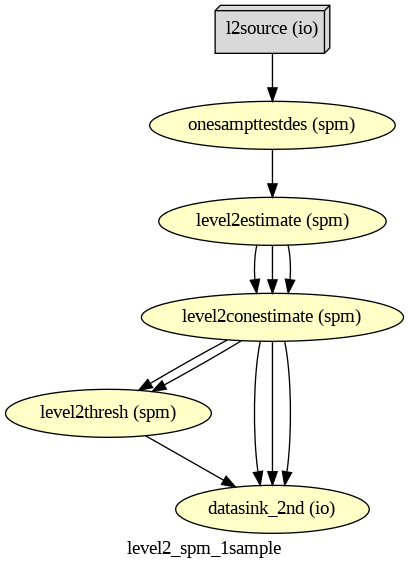

In [40]:
from IPython.display import Image
wf_2ndlevel_onesample.write_graph(graph2use='colored', format='png', simple_form=True)

Image(filename=opj(wf_2ndlevel_onesample.base_dir, wf_2ndlevel_onesample.name, 'graph.png'))

In [41]:
wf_2ndlevel_onesample.run(plugin="MultiProc")
# 2min

240613-06:44:11,692 nipype.workflow INFO:
	 Workflow level2_spm_1sample settings: ['check', 'execution', 'logging', 'monitoring']
240613-06:44:11,713 nipype.workflow INFO:
	 Running in parallel.
240613-06:44:11,716 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:44:12,343 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.l2source" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_5/l2source".
240613-06:44:12,343 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.l2source" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_6/l2source".
240613-06:44:12,344 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.l2source" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_7/l2source".
240613-06:44:12,345 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.l2

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:44:33,891 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_6/level2estimate".
240613-06:44:33,892 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_8/level2estimate".
240613-06:44:33,892 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_7/level2estimate".
240613-06:44:33,893 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_9/level2estimate".
240613-06:44:33,894 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_10/l

stty: 'standard input': Inappropriate ioctl for device


240613-06:44:35,719 nipype.workflow INFO:
	 [Job 6] Completed (level2_spm_1sample.onesampttestdes).
240613-06:44:35,721 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 1 jobs ready. Free memory (GB): 218.48/219.48, Free processors: 27/32.
                     Currently running:
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
240613-06:44:35,922 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_5/level2estimate".
240613-06:44:35,938 nipype.workflow INFO:
	 [Node] Executing "level2estimate" <nipype.interfaces.spm.model.EstimateModel>
240613-06:44:37,722 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 0 jobs ready. F

stty: 'standard input': Inappropriate ioctl for device


240613-06:44:53,723 nipype.workflow INFO:
	 [Job 17] Completed (level2_spm_1sample.level2estimate).
240613-06:44:53,725 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 1 jobs ready. Free memory (GB): 218.48/219.48, Free processors: 27/32.
                     Currently running:
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
                       * level2_spm_1sample.level2estimate
240613-06:44:53,959 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2conestimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_10/level2conestimate".
240613-06:44:53,973 nipype.workflow INFO:
	 [Node] Executing "level2conestimate" <nipype.interfaces.spm.model.EstimateContrast>
240613-06:44:54,127 nipype.workflow INFO:
	 [Node] Finished "level2estimate", e

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:44:54,353 nipype.workflow INFO:
	 [Node] Finished "level2estimate", elapsed time 20.448029s.


stty: 'standard input': Inappropriate ioctl for device


240613-06:44:54,574 nipype.workflow INFO:
	 [Node] Finished "level2estimate", elapsed time 20.667891s.


stty: 'standard input': Inappropriate ioctl for device


240613-06:44:55,724 nipype.workflow INFO:
	 [Job 13] Completed (level2_spm_1sample.level2estimate).
240613-06:44:55,725 nipype.workflow INFO:
	 [Job 14] Completed (level2_spm_1sample.level2estimate).
240613-06:44:55,726 nipype.workflow INFO:
	 [Job 15] Completed (level2_spm_1sample.level2estimate).
240613-06:44:55,727 nipype.workflow INFO:
	 [Job 16] Completed (level2_spm_1sample.level2estimate).
240613-06:44:55,729 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 4 jobs ready. Free memory (GB): 219.08/219.48, Free processors: 30/32.
                     Currently running:
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2estimate
240613-06:44:55,869 nipype.workflow INFO:
	 [Node] Finished "level2estimate", elapsed time 19.928532s.
240613-06:44:55,890 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2conestimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_6

stty: 'standard input': Inappropriate ioctl for device


240613-06:44:57,730 nipype.workflow INFO:
	 [Job 12] Completed (level2_spm_1sample.level2estimate).
240613-06:44:57,732 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 1 jobs ready. Free memory (GB): 218.48/219.48, Free processors: 27/32.
                     Currently running:
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
240613-06:44:57,877 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2conestimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_5/level2conestimate".
240613-06:44:57,893 nipype.workflow INFO:
	 [Node] Executing "level2conestimate" <nipype.interfaces.spm.model.EstimateContrast>
240613-06:44:59,725 nipype.workflow INFO:
	 [MultiProc] Running 6

stty: 'standard input': Inappropriate ioctl for device


240613-06:45:19,725 nipype.workflow INFO:
	 [Node] Finished "level2conestimate", elapsed time 23.819495s.
240613-06:45:19,728 nipype.workflow INFO:
	 [Job 23] Completed (level2_spm_1sample.level2conestimate).
240613-06:45:19,730 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 1 jobs ready. Free memory (GB): 218.48/219.48, Free processors: 27/32.
                     Currently running:
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
                       * level2_spm_1sample.level2conestimate
240613-06:45:19,835 nipype.workflow INFO:
	 [Node] Finished "level2conestimate", elapsed time 23.929947s.
240613-06:45:19,863 nipype.workflow INFO:
	 [Node] Finished "level2conestimate", elapsed time 23.956484s.
240613-06:45:19,913 nipype.workflow INFO:
	 [Node] Finished "level2conestimate", 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:45:19,905 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2thresh" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_10/level2thresh".
240613-06:45:19,944 nipype.workflow INFO:
	 [Node] Executing "level2thresh" <nipype.interfaces.spm.model.Threshold>
240613-06:45:21,728 nipype.workflow INFO:
	 [Job 19] Completed (level2_spm_1sample.level2conestimate).
240613-06:45:21,730 nipype.workflow INFO:
	 [Job 20] Completed (level2_spm_1sample.level2conestimate).
240613-06:45:21,731 nipype.workflow INFO:
	 [Job 21] Completed (level2_spm_1sample.level2conestimate).
240613-06:45:21,732 nipype.workflow INFO:
	 [Job 22] Completed (level2_spm_1sample.level2conestimate).
240613-06:45:21,734 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 4 jobs ready. Free memory (GB): 219.08/219.48, Free processors: 30/32.
                     Currently running:
                       * level2_spm_1sample.level2thresh
                       * le

stty: 'standard input': Inappropriate ioctl for device


240613-06:45:23,728 nipype.workflow INFO:
	 [Job 18] Completed (level2_spm_1sample.level2conestimate).
240613-06:45:23,730 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 1 jobs ready. Free memory (GB): 218.48/219.48, Free processors: 27/32.
                     Currently running:
                       * level2_spm_1sample.level2thresh
                       * level2_spm_1sample.level2thresh
                       * level2_spm_1sample.level2thresh
                       * level2_spm_1sample.level2thresh
                       * level2_spm_1sample.level2thresh
240613-06:45:23,932 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.level2thresh" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_5/level2thresh".
240613-06:45:23,945 nipype.workflow INFO:
	 [Node] Executing "level2thresh" <nipype.interfaces.spm.model.Threshold>
240613-06:45:25,729 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 0 jobs ready. Free memory (GB): 

stty: 'standard input': Inappropriate ioctl for device


240613-06:45:33,894 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.datasink_2nd" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_10/datasink_2nd".
240613-06:45:33,906 nipype.workflow INFO:
	 [Node] Executing "datasink_2nd" <nipype.interfaces.io.DataSink>
240613-06:45:33,909 nipype.interface INFO:
	 sub: /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_results_1sample/2ndLevel/_con_10/SPM.mat -> /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_results_1sample/con10/SPM.mat
240613-06:45:33,910 nipype.interface INFO:
	 sub: /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_results_1sample/2ndLevel/_con_10/spmT_0001.nii -> /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_results_1sample/con10/spmT_0001.nii
240613-06:45:33,911 nipype.interface INFO:
	 sub: /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_results_1sample/2ndLevel/_con_10/con_

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:45:37,729 nipype.workflow INFO:
	 [Job 25] Completed (level2_spm_1sample.level2thresh).
240613-06:45:37,731 nipype.workflow INFO:
	 [Job 26] Completed (level2_spm_1sample.level2thresh).
240613-06:45:37,732 nipype.workflow INFO:
	 [Job 27] Completed (level2_spm_1sample.level2thresh).
240613-06:45:37,734 nipype.workflow INFO:
	 [Job 28] Completed (level2_spm_1sample.level2thresh).
240613-06:45:37,736 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jobs ready. Free memory (GB): 219.28/219.48, Free processors: 31/32.
                     Currently running:
                       * level2_spm_1sample.level2thresh
240613-06:45:37,771 nipype.workflow INFO:
	 [Node] Finished "level2thresh", elapsed time 13.824073s.
240613-06:45:37,904 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.datasink_2nd" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_8/datasink_2nd".
240613-06:45:37,904 nipype.workflow INFO:
	 [Node] Setting-up "

stty: 'standard input': Inappropriate ioctl for device


240613-06:45:39,729 nipype.workflow INFO:
	 [Job 24] Completed (level2_spm_1sample.level2thresh).
240613-06:45:39,731 nipype.workflow INFO:
	 [Job 31] Completed (level2_spm_1sample.datasink_2nd).
240613-06:45:39,732 nipype.workflow INFO:
	 [Job 32] Completed (level2_spm_1sample.datasink_2nd).
240613-06:45:39,733 nipype.workflow INFO:
	 [Job 33] Completed (level2_spm_1sample.datasink_2nd).
240613-06:45:39,734 nipype.workflow INFO:
	 [Job 34] Completed (level2_spm_1sample.datasink_2nd).
240613-06:45:39,735 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:45:39,888 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_1sample.datasink_2nd" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_1sample/_con_5/datasink_2nd".
240613-06:45:39,895 nipype.workflow INFO:
	 [Node] Executing "datasink_2nd" <nipype.interfaces.io.DataSink>
240613-06:45:39,921 nipype.interface INFO:
	 sub: /mnt/

#### 2.1 Two Sample T-Test: Main effect of face, Interaction Face x Repetition

Main effect of face: enter the following 2 contrasts per subject into a two-sample t-test and use 1 0, 0 1 F contrast
- con_0006: Positive Effect F>S 

- con_0007: Positive Effect S>U



Interaction Face x Rep: enter the following 2 contrasts per subject into a two-sample t-test and use 1 0, 0 1 F contrast
- con_0009: Positive Interaction Face (F/S) x Rep 

- con_0010: Positive Interaction Face (S/U) x Rep

In [42]:
wf_2ndlevel_twosample = Workflow(name='level2_spm_2sample', base_dir=experiment_dir)
wf_2ndlevel_twosample.config["execution"]["crashfile_format"] = "txt"

In [43]:
contrast_id_1 = [6] #con_0006
contrast_id_2 = [7] #con_0007 

l2source2 = Node(DataGrabber(outfields=["group_1", "group_2"]), name='l2source')

l2source2.inputs.sort_filelist = True
l2source2.inputs.contrast_id_1 = contrast_id_1
l2source2.inputs.contrast_id_2 = contrast_id_2
l2source2.inputs.base_directory = opj(experiment_dir, 'level1_spm_results')
l2source2.inputs.template = '*' 

l2source2.inputs.template_args = dict(
    group_1=[["contrast_id_1"]],
    group_2=[["contrast_id_2"]])

l2source2.inputs.field_template = dict(
    group_1 = "*/con_%04d.nii",
    group_2 ="*/con_%04d.nii", 
)

In [44]:
# SecondLevelDesign - TwoSampleTTestDesign bases Factorial Design
twosamplettestdes = Node(interface=spm.TwoSampleTTestDesign(), name="twosampttestdes")
twosamplettestdes.inputs.dependent = False # measurements dependent between levels
twosamplettestdes.inputs.unequal_variance = True # equal or unequal between groups

wf_2ndlevel_twosample.connect([(l2source2, twosamplettestdes, [('group_1', 'group1_files')]),
                             (l2source2, twosamplettestdes, [('group_2', 'group2_files')])])

In [45]:
l2estimate2 = Node(spm.EstimateModel(estimation_method={'Classical':1}), name='level2estimate')

# EstimateContast - estimates group contrast
l2conestimate2 = Node(spm.EstimateContrast(group_contrast=True), name = 'level2conestimate')

con_1 = ('Pos effect level 1','T', ['Group_{1}', 'Group_{2}'],[1, 0])
con_2 = ('Pos effect level 2','T', ['Group_{1}', 'Group_{2}'],[0, 1])

con_3 = ('Main effect', 'F', [con_1, con_2]) # main effect of face

l2conestimate2.inputs.contrasts = [con_1, con_2, con_3] 


# Threshold - thresholds contrasts
level2thresh2 = MapNode(spm.Threshold(contrast_index=3,# which contrast in the SPM.mat to use --> here set for con_3: main effect
                                use_topo_fdr=True, # whether to use FDR over cluster extent probabilities
                                use_fwe_correction=False, # whether to use FWE (Bonferroni) correction for initial threshold 
                                extent_threshold=0, # minimum cluster size in voxels
                                height_threshold=0.005, # value for initial thresholding (defining clusters) - voxelwise
                                height_threshold_type='p-value',
                                extent_fdr_p_threshold=0.05), # P threshold on FDR corrected cluster size probabilities
                                iterfield=['stat_image'],
                                name='level2thresh')

wf_2ndlevel_twosample.connect([(twosamplettestdes, l2estimate2, [('spm_mat_file', 'spm_mat_file')]),
                    (l2estimate2, l2conestimate2, [('spm_mat_file', 'spm_mat_file'),
                                                ('beta_images', 'beta_images'),
                                                ('residual_image', 'residual_image')]),
                    (l2conestimate2, level2thresh2, [('spm_mat_file', 'spm_mat_file'),
                                                    ('spmT_images', 'stat_image')])
                    ])

In [46]:
datasink_2nd_2 = Node(DataSink(), name='datasink_2nd_2')
datasink_2nd_2.inputs.base_directory=opj(experiment_dir, 'level2_spm_results_2sample')

wf_2ndlevel_twosample.connect([(l2conestimate2, datasink_2nd_2, [('spm_mat_file', '2ndLevel.@spm_mat'),
                                                    ('spmT_images', '2ndLevel.@T'),
                                                    ('con_images', '2ndLevel.@con')]),
                    (level2thresh2, datasink_2nd_2, [('thresholded_map',
                                                '2ndLevel.@threshold')])                                                 
                    ])

In [47]:
subFolders = [('2ndLevel/', 'MainEffectFace/')]
subFolders1 = [('_con_', 'con')] 
subFolders2 = [('_level2thresh0', 'thresh_con1')]
subFolders3 = [('_level2thresh1', 'thresh_con2')]
subFolders4 = [('_level2thresh2', 'thresh_con3')]


subFolders.extend(subFolders1)
subFolders.extend(subFolders2)
subFolders.extend(subFolders3)
subFolders.extend(subFolders4)

datasink_2nd_2.inputs.substitutions = subFolders

240613-06:45:44,410 nipype.workflow INFO:
	 Generated workflow graph: /mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/graph.png (graph2use=colored, simple_form=True).


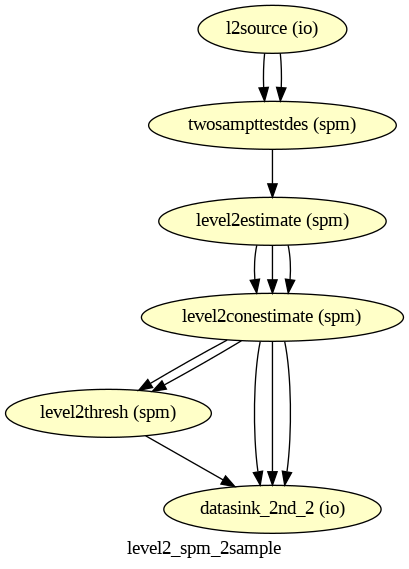

In [48]:
from IPython.display import Image
wf_2ndlevel_twosample.write_graph(graph2use='colored', format='png', simple_form=True)

Image(filename=opj(wf_2ndlevel_twosample.base_dir, wf_2ndlevel_twosample.name, 'graph.png'))

In [49]:
wf_2ndlevel_twosample.run(plugin="MultiProc")

240613-06:45:44,421 nipype.workflow INFO:
	 Workflow level2_spm_2sample settings: ['check', 'execution', 'logging', 'monitoring']
240613-06:45:44,427 nipype.workflow INFO:
	 Running in parallel.
240613-06:45:44,429 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:45:44,938 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_2sample.l2source" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/l2source".
240613-06:45:44,946 nipype.workflow INFO:
	 [Node] Executing "l2source" <nipype.interfaces.io.DataGrabber>
240613-06:45:44,952 nipype.workflow INFO:
	 [Node] Finished "l2source", elapsed time 0.00239s.
240613-06:45:46,432 nipype.workflow INFO:
	 [Job 0] Completed (level2_spm_2sample.l2source).
240613-06:45:46,436 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:45:46,685 nipype.wor

stty: 'standard input': Inappropriate ioctl for device


240613-06:46:02,431 nipype.workflow INFO:
	 [Job 1] Completed (level2_spm_2sample.twosampttestdes).
240613-06:46:02,433 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:46:02,580 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_2sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2estimate".
240613-06:46:02,590 nipype.workflow INFO:
	 [Node] Executing "level2estimate" <nipype.interfaces.spm.model.EstimateModel>
240613-06:46:04,432 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 219.28/219.48, Free processors: 31/32.
                     Currently running:
                       * level2_spm_2sample.level2estimate
240613-06:46:22,491 nipype.workflow INFO:
	 [Node] Finished "level2estimate", elapsed time 19.898428s.


stty: 'standard input': Inappropriate ioctl for device


240613-06:46:24,433 nipype.workflow INFO:
	 [Job 2] Completed (level2_spm_2sample.level2estimate).
240613-06:46:24,435 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:46:24,580 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_2sample.level2conestimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2conestimate".
240613-06:46:24,595 nipype.workflow INFO:
	 [Node] Executing "level2conestimate" <nipype.interfaces.spm.model.EstimateContrast>
240613-06:46:26,434 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 219.28/219.48, Free processors: 31/32.
                     Currently running:
                       * level2_spm_2sample.level2conestimate
240613-06:46:41,400 nipype.workflow INFO:
	 [Node] Finished "level2conestimate", elapsed time 16.802565s.


stty: 'standard input': Inappropriate ioctl for device


240613-06:46:42,435 nipype.workflow INFO:
	 [Job 3] Completed (level2_spm_2sample.level2conestimate).
240613-06:46:42,437 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:46:44,435 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:46:44,580 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh0" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh0".
240613-06:46:44,581 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh1" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh1".
240613-06:46:44,582 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh2" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh2".
240613-0

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:46:58,442 nipype.workflow INFO:
	 [Job 6] Completed (_level2thresh0).
240613-06:46:58,444 nipype.workflow INFO:
	 [Job 7] Completed (_level2thresh1).
240613-06:46:58,445 nipype.workflow INFO:
	 [Job 8] Completed (_level2thresh2).
240613-06:46:58,446 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:46:58,601 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh0" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh0".
240613-06:46:58,606 nipype.workflow INFO:
	 [Node] Cached "_level2thresh0" - collecting precomputed outputs
240613-06:46:58,608 nipype.workflow INFO:
	 [Node] "_level2thresh0" found cached.
240613-06:46:58,609 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh1" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh1".
240613-06:46:58,611 nipype

In [50]:
contrast_id_1 = [9] #con_0009
contrast_id_2 = [10] #con_0010 

l2source2.inputs.contrast_id_1 = contrast_id_1
l2source2.inputs.contrast_id_2 = contrast_id_2

subFolders = [('2ndLevel/', 'InteractionFace_Repetition/')]
subFolders.extend(subFolders1)
subFolders.extend(subFolders2)
subFolders.extend(subFolders3)
subFolders.extend(subFolders4)

datasink_2nd_2.inputs.substitutions = subFolders

wf_2ndlevel_twosample.run(plugin="MultiProc")

240613-06:47:04,529 nipype.workflow INFO:
	 Workflow level2_spm_2sample settings: ['check', 'execution', 'logging', 'monitoring']
240613-06:47:04,536 nipype.workflow INFO:
	 Running in parallel.
240613-06:47:04,538 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:47:04,680 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.l2source".
240613-06:47:05,42 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_2sample.l2source" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/l2source".
240613-06:47:05,46 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.l2source".
240613-06:47:05,57 nipype.workflow INFO:
	 [Node] Executing "l2source" <nipype.interfaces.io.DataGrabber>
240613-06:47:05,75 nipype.workflow INFO:
	 [Node] Finished "l2source", elapsed time 0.002216s.
240613-06:47:06,547 nipype.workflow INFO:
	 [Job 0] Complete

stty: 'standard input': Inappropriate ioctl for device


240613-06:47:22,685 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.level2estimate".
240613-06:47:22,690 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_2sample.level2estimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2estimate".
240613-06:47:22,694 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.level2estimate".
240613-06:47:22,704 nipype.workflow INFO:
	 [Node] Executing "level2estimate" <nipype.interfaces.spm.model.EstimateModel>
240613-06:47:24,541 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 219.28/219.48, Free processors: 31/32.
                     Currently running:
                       * level2_spm_2sample.level2estimate
240613-06:47:42,212 nipype.workflow INFO:
	 [Node] Finished "level2estimate", elapsed time 19.50542s.


stty: 'standard input': Inappropriate ioctl for device


240613-06:47:42,541 nipype.workflow INFO:
	 [Job 2] Completed (level2_spm_2sample.level2estimate).
240613-06:47:42,543 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:47:42,685 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.level2conestimate".
240613-06:47:42,691 nipype.workflow INFO:
	 [Node] Setting-up "level2_spm_2sample.level2conestimate" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2conestimate".
240613-06:47:42,696 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.level2conestimate".
240613-06:47:42,705 nipype.workflow INFO:
	 [Node] Executing "level2conestimate" <nipype.interfaces.spm.model.EstimateContrast>
240613-06:47:44,542 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 219.28/219.48, Free processors: 31/32.
                     Currently running:
   

stty: 'standard input': Inappropriate ioctl for device


240613-06:48:00,543 nipype.workflow INFO:
	 [Job 3] Completed (level2_spm_2sample.level2conestimate).
240613-06:48:00,545 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:48:02,543 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:48:02,691 nipype.workflow INFO:
	 [Node] Outdated cache found for "_level2thresh0".
240613-06:48:02,694 nipype.workflow INFO:
	 [Node] Outdated cache found for "_level2thresh1".
240613-06:48:02,696 nipype.workflow INFO:
	 [Node] Outdated cache found for "_level2thresh2".
240613-06:48:02,696 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh0" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh0".
240613-06:48:02,701 nipype.workflow INFO:
	 [Node] Outdated cache found for "_level2thresh0".
240613-06:48:02,698 nipype.w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240613-06:48:16,544 nipype.workflow INFO:
	 [Job 6] Completed (_level2thresh0).
240613-06:48:16,546 nipype.workflow INFO:
	 [Job 7] Completed (_level2thresh1).
240613-06:48:16,546 nipype.workflow INFO:
	 [Job 8] Completed (_level2thresh2).
240613-06:48:16,547 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
240613-06:48:16,695 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.level2thresh".
240613-06:48:16,706 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2_spm_2sample.level2thresh".
240613-06:48:16,723 nipype.workflow INFO:
	 [Node] Setting-up "_level2thresh0" in "/mnt/neurodesktop-storage/Examples_neurodesk/spm_analysis/level2_spm_2sample/level2thresh/mapflow/_level2thresh0".
240613-06:48:16,727 nipype.workflow INFO:
	 [Node] Cached "_level2thresh0" - collecting precomputed outputs
240613-06:48:16,728 nipype.workflow INFO:
	 [Node] "_level2thresh0" found cached.
24

## Results
The group analysis was only done on N=9 subjects, a voxel-wise threshold of p<0.005 was chosen and a cluster-wise FDR threshold of p<0.05 to correct for multiple comparisons.

### Look at the positive effect using the plot_stat_map plotting method of nilearn

/opt/conda/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


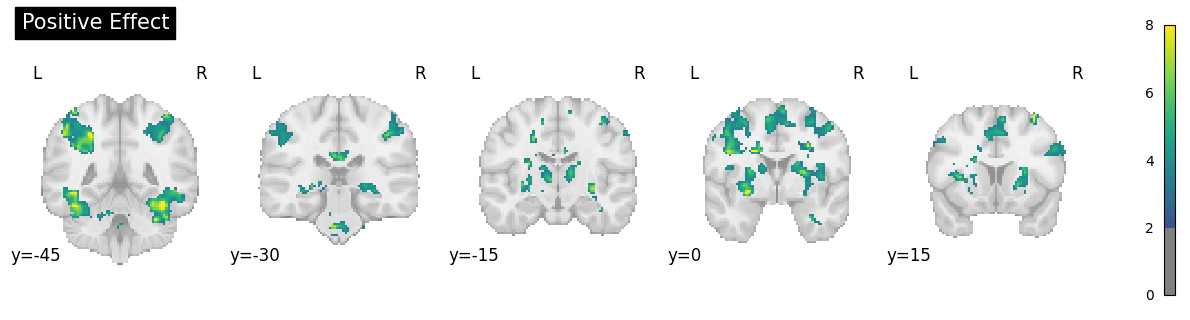

In [51]:
plotting.plot_stat_map(opj(experiment_dir, 'level2_spm_results_1sample/con5/spmT_0001_thr.nii'), title='Positive Effect', dim=1, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), threshold=2, vmax=8, cmap='viridis');

#### Look at the results using the glass brain plotting method of nilearn

/opt/conda/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:1471: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


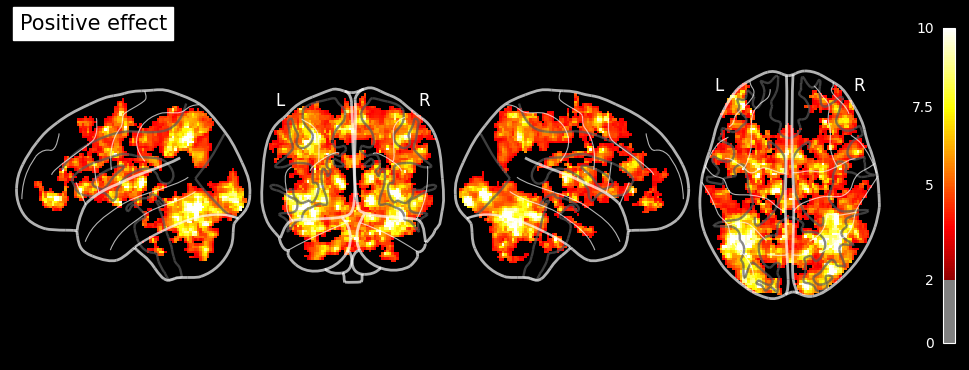

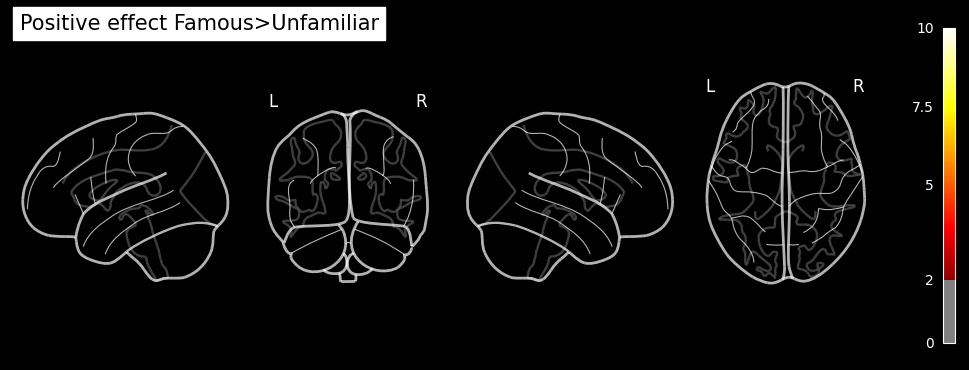

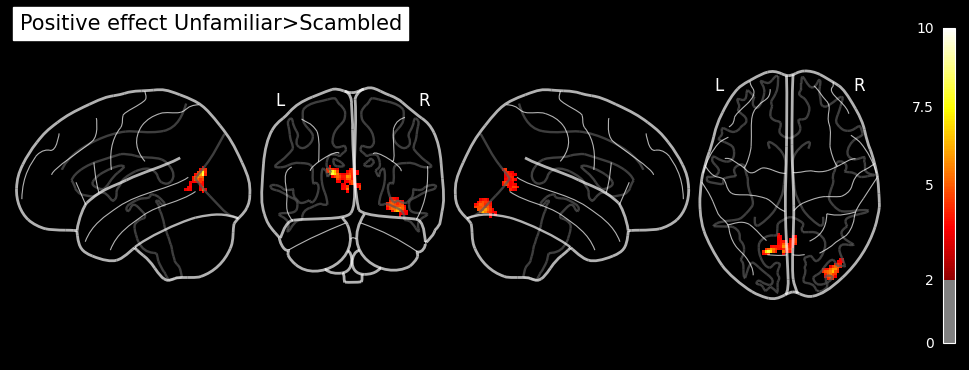

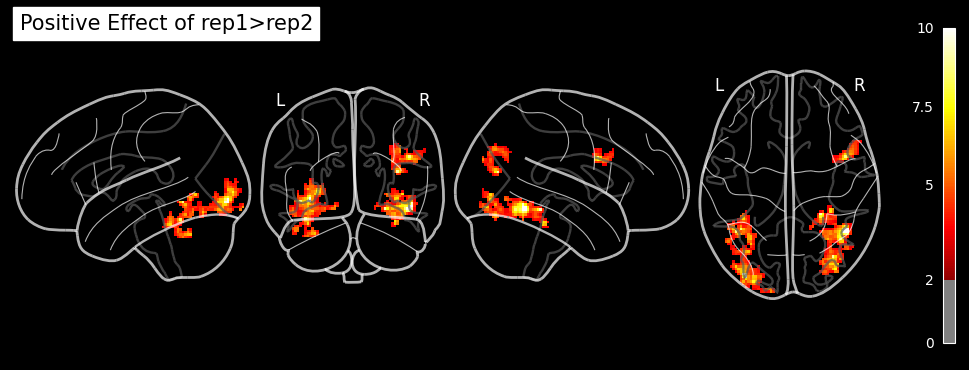

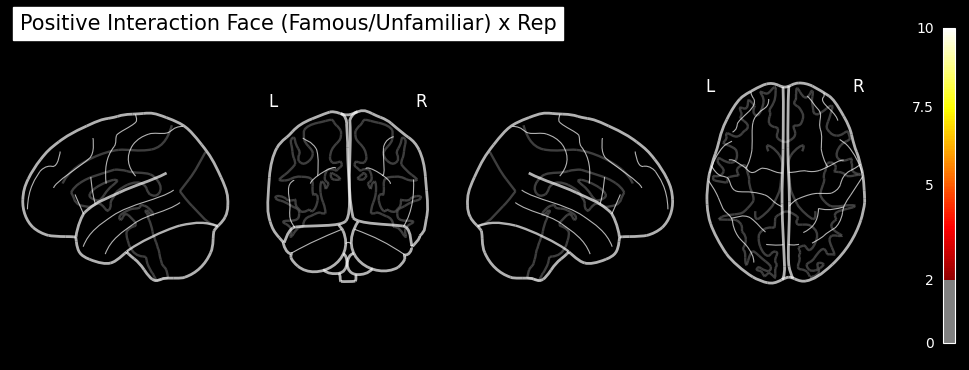

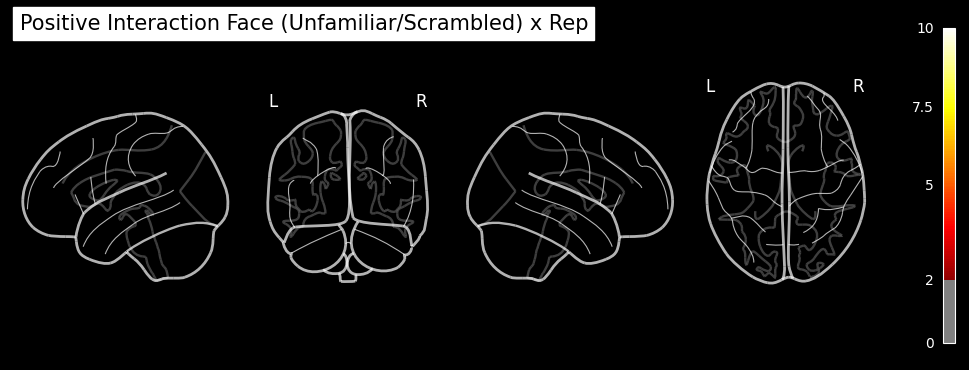

In [52]:
plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_1sample/con5/spmT_0001_thr.nii'), 
                          colorbar=True, threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Positive effect');

plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_1sample/con6/spmT_0001_thr.nii'), 
                          colorbar=True, threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Positive effect Famous>Unfamiliar');

plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_1sample/con7/spmT_0001_thr.nii'), 
                          colorbar=True, threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Positive effect Unfamiliar>Scambled');

plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_1sample/con8/spmT_0001_thr.nii'), 
                          colorbar=True, threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Positive Effect of rep1>rep2');

plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_1sample/con9/spmT_0001_thr.nii'), 
                          colorbar=True, threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Positive Interaction Face (Famous/Unfamiliar) x Rep');

plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_1sample/con10/spmT_0001_thr.nii'), 
                          colorbar=True, threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Positive Interaction Face (Unfamiliar/Scrambled) x Rep');

#### Visualize main effects face and interaction face x repetition

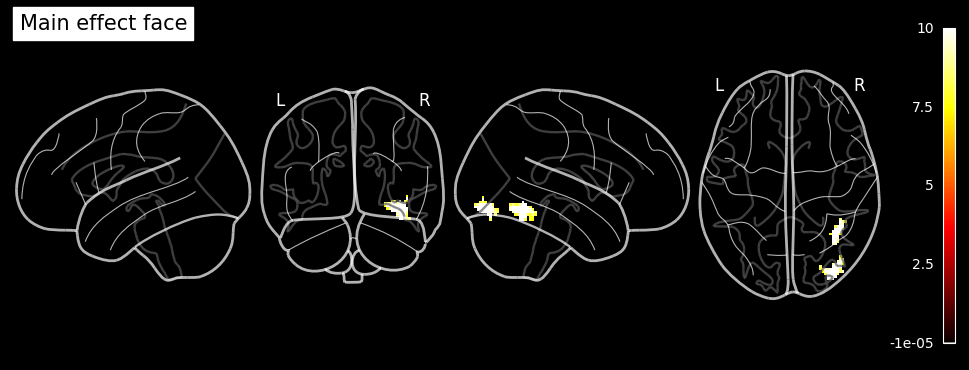

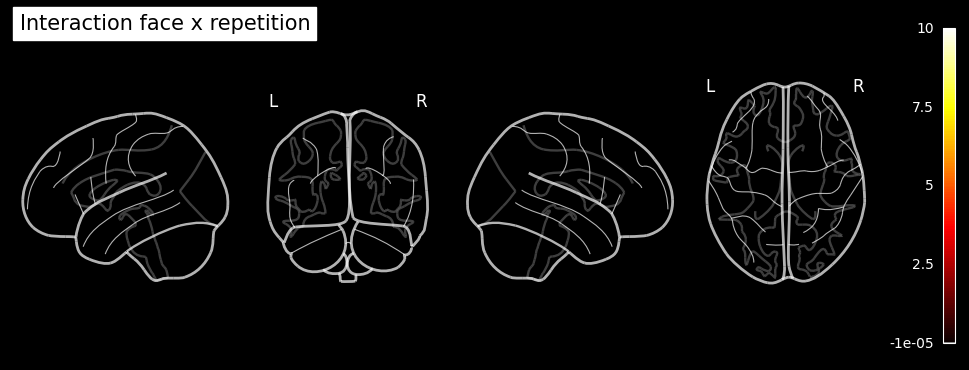

In [53]:
plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_2sample/MainEffectFace/thresh_con3/spmF_0003_thr.nii'), 
                          colorbar=True, display_mode='lyrz', black_bg=True, vmax=10, title='Main effect face');


plotting.plot_glass_brain(opj(experiment_dir, 'level2_spm_results_2sample/InteractionFace_Repetition/thresh_con3/spmF_0003_thr.nii'), 
                          colorbar=True, display_mode='lyrz', black_bg=True, vmax=10, title='Interaction face x repetition');